In [ ]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import library
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
from keras import optimizers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from numpy import savetxt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Wanshouxigong.csv to Wanshouxigong.csv


In [ ]:
data=read_csv("Wanshouxigong.csv")
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2


In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('Wanshouxigong.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])

In [ ]:
dataset.drop("No", axis=1, inplace=True)

In [ ]:
dataset=dataset.fillna(method="pad")

In [ ]:
dataset.isnull().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

In [ ]:
dataset_columns = dataset.columns.tolist()
dataset_columns

['PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'wd',
 'WSPM']

In [ ]:
temp_cols=dataset.columns.tolist()
index=dataset.columns.get_loc("CO")
new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
dataset=dataset[new_cols]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = dataset.values
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])
values = values.astype('float32')
values[:,10]

array([14., 14., 14., ...,  7.,  6.,  5.], dtype=float32)

In [ ]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [ ]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 24
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [ ]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (35040, 1)
X (35040, 24, 12)


In [ ]:
#Splitting the dataset
n_train = 24*365
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (26280, 24, 12)
X_test (8760, 24, 12)
Y_train (26280, 1)
Y_test (8760, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')

In [ ]:
history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size = 64, verbose=1)

Epoch 1/100
411/411 [==============================] - 3s 5ms/step - loss: 0.0094 - val_loss: 0.0046
Epoch 2/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 3/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 4/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 5/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 6/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 7/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 8/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 10/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0027 - val_lo

In [ ]:
from keras.models import load_model
model_cnn.save('AirPollutionCNN.h5')

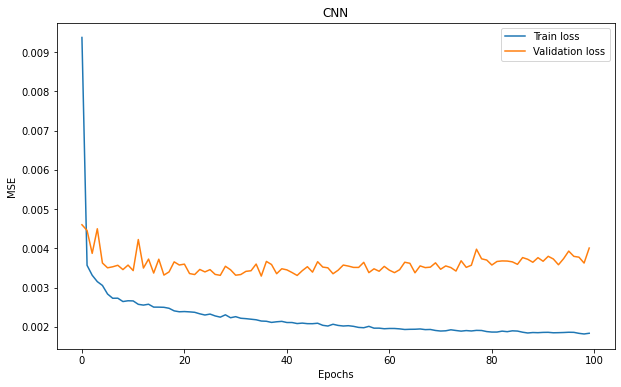

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("CNN")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
plt.savefig('graph_CNN.png')

In [ ]:
RMSE1=[]
RMAE1=[]
MAPE1=[]
R22=[]

for i in range(40, 181, 5):
  Y_pred = model_cnn.predict(X_test[:i,:])
  #print(Y_pred)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:i,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  Y_predicted = scaler.inverse_transform(Y_predicted)
  Y_tested = scaler.inverse_transform(Y_tested)
  Y_predicted = Y_predicted[:,0]
  Y_tested = Y_tested[:i,0]
  mse = mean_squared_error(Y_tested, Y_predicted)
  rmse = np.sqrt(mse)
  print("RMSE at %s = %s" % (i, rmse))
  RMSE1=np.append(RMSE1,rmse)
  mae = mean_absolute_error(Y_tested, Y_predicted)
  rmae = np.sqrt(mae)
  RMAE1=np.append(RMAE1,rmae)
  print("RMAE at %s = %s" % (i, rmae))
  mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
  print("MAPE at %s = %s" % (i, mape))
  MAPE1=np.append(MAPE1,mape)
  #R2 score
  R2 = r2_score( Y_predicted, Y_tested)
  print("R2 at %s = %s" % (i, R2))
  R22=np.append(R22,R2)

2/2 [==============================] - 0s 5ms/step
RMSE at 40 = 395.0231
RMAE at 40 = 16.852623
MAPE at 40 = 0.24288276
R2 at 40 = 0.8154475761096461
2/2 [==============================] - 0s 5ms/step
RMSE at 45 = 417.51865
RMAE at 45 = 17.432514
MAPE at 45 = 0.25962377
R2 at 45 = 0.7805726748725084
2/2 [==============================] - 0s 6ms/step
RMSE at 50 = 454.8309
RMAE at 50 = 18.372412
MAPE at 50 = 0.28822812
R2 at 50 = 0.715357525830536
2/2 [==============================] - 0s 5ms/step
RMSE at 55 = 501.7995
RMAE at 55 = 19.201553
MAPE at 55 = 0.39753366
R2 at 55 = 0.6378365031388105
2/2 [==============================] - 0s 5ms/step
RMSE at 60 = 487.74167
RMAE at 60 = 18.8198
MAPE at 60 = 0.38183028
R2 at 60 = 0.6626655470523813
3/3 [==============================] - 0s 3ms/step
RMSE at 65 = 472.03918
RMAE at 65 = 18.407085
MAPE at 65 = 0.38216108
R2 at 65 = 0.6986791827475483
3/3 [==============================] - 0s 3ms/step
RMSE at 70 = 464.3391
RMAE at 70 = 18.245409
MAPE

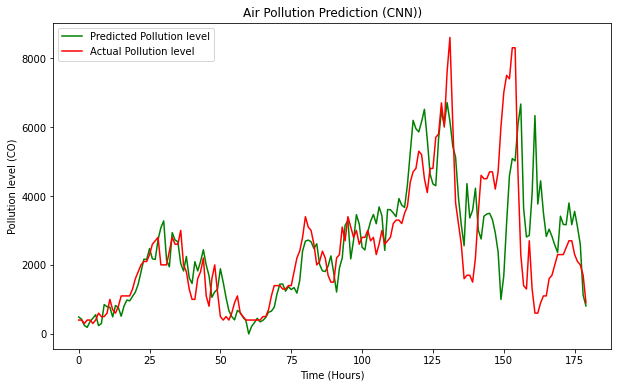

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted, color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (CNN))")
plt.xlabel("Time (Hours)")
plt.ylabel("Pollution level (CO)")
plt.legend()
plt.show()
plt.savefig('graphCNN.png')

In [ ]:
savetxt('Predict_CNN_CO.csv', Y_predicted, delimiter=',')

In [ ]:
savetxt('Test_CNN_CO.csv', Y_tested, delimiter=',')